# Thermal Model for CubeSat

The aim of this tutorial is to set up a satellite thermal nodal model in order to assess the power requirements of the thermal control system.

##  Illumination of satellites

Cubsat satellites are generally located in low earth orbit (LEO) at an altitude of between 400 and 600 km.  Their speed is very high, around 27500 km/h or 450 km/min or 7.6 km/s. One rotation around the Earth takes around 90 minutes, and is usually done along an axis perpendicular to the equator. There are therefore around 16 rotations in 24 hours. Their thermal behaviour is strongly influenced by solar radiation and the [Earth's shadows](http://sesp.esep.pro/fr/pages_nanosats/index.html). 

*Earth shadow:*
![Earth shadow](./figures/pression-radiation-solaire-zone-ombre.png)
    

## Two nodes thermal model

The paper [[Rossi, 2013](#References)] outlines the creation of a Thermal Model Analysis for a CubeSat as based on the SwissCube's flight data from 2009 to 2012. The external faces and internal components of the CubeSat were simplified into two nodes of the aforementioned respective general locations, with the external node pertaining to a spherical surface representative of the six faces of a CubeSat 1U at mean temperature, and the internal node being based on the thermally controlled battery pack. 

*SwissCube thermal model:* 
![SwissCubeThermalModel](./figures/SwissCubeThermalModel.PNG)

The above illustrated figures show the simplified two node model defined to eventually simulate heat transfers between and within the internal and external references of a cube satellite (left), and the comparison or validation of the created thermal model by [[Rossi, 2013](#References)] as compared to the actual experimental data from the SwissCube satellite (right).

The heat transfer in terms of conduction and radiation were analyzed with each node's interactions with the environment and with each other were taken into account with respect to the Fourier and Stefan-Boltzmann Equations, as well as Lambert's law, to ultimately arrive to the following equations:<br><br>
[1] Solar Radiation: $$q_s=A_s\alpha_sJ_s$$
[2] Infrared from Earth: $$q_p=A_pF_{s-p}\varepsilon\sigma_nT_p^4$$
[3] Albedo: $$q_a=A_pF_a\alpha_sJ_sa$$
[4] Radiation to Deep Space: $$q_r=A_r\varepsilon\sigma_nT^4$$<br>
Among which the first three equations refer to heat input, and the last to heat output. Where $A$ generally refers to the area, $\alpha$ the absorptivity, $J_s$ the Solar Constant mean value, $F$ the geometric view factor, $\varepsilon$ the emmisivity, $\sigma$ the Stefan-Boltzmann constant, and $T$ the absolute temperature. 



In a more general context, the following equation was used, and the coefficients K and R were derived from the assumption of two concentric nodal spheres with specified radii.  
$C_i\frac{dT_i}{dt}=\sum_{i\not=j}K_{ij}(T_j-T_i)+\sum_{i\not=j}R_{ij}(T_j^4-T_i^4)+q_i$, i,j=1,...,n$  

$K=\frac{4\pi\lambda r_{int}r_{ext}}{r_{ext}-r_{int}}$  
$R=\frac{4\pi r_{int}^2}{\frac{1}{\varepsilon_{int}}+\frac{1-\varepsilon_{ext}}{\varepsilon_{ext}}(\frac{r_{int}}{r_{ext}})^2}$  

$R_{int}$ and $\lambda$ parameters was tuned given the flight data and theoretical values. The above figure shows the differential equation with respect to the evolution of time in the system. Overall, the simplified model was proven to be close and consistent in terms of slopes with regards to the actual flight data. To be able to use this lumped parameters model, it is necessary to adapt the value of the parameters to the configurations of interest.

*Tuned SwissCube parameters:*
<img src="./figures/SwissCubeParameters.png" width="300">


In [48]:
import math  
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

S = 0.06 # [m²] Cubesat surface
A = 0.06462 # [m²] Total area for heat transfers
A_s = 0.03231 # [m²] Area facing the sun
A_p = 0.03231 # [m²] Area facing the planet
A_r = 0.06462 # [m²] Radiating area
F_sp = 0.5 # [-] view factor between CubeSat and the planet
F_a = 0.5 # [-] view factor for the Albedo
J_s = 1366 # [W/m²] Mean of the Sun Power
E_ext = 0.9 # [-] Emissivity surface
E_int = 0.8 # [-] Emissivity internal part
SB_const = 5.67e-8 # [-] Stefan Boltzman constant
a = 0.34 # [-] Mean albedo value
T_p = 288 # [-] Planet temperature
ABS_const = 0.65 # [K] Absorbance coefficient
C_int = 80 # [J/K] Internal node capacity
C_ext = 570  # [J/K] External node capacity
HC = 0.25 # [W/mK] Heat conductivity
T = 3 # [K] temperature for deep space

q_p = A_p*F_sp*E_ext*SB_const*(T_p**4) # Planet radiation
q_r = A_r*E_ext*SB_const*(T**4) # Deep space radiation

## Modelica implementation

The figure below shows a Modelica model implementing the various heat transfers described above. The time diagram opposite represents the temporal evolution of the two thermal capacities or nodes of this model.  

*Modelica Model:*
![Modelica model](./figures/2nodesModelicaModel.png)

> **Question:** indicate the different phenomena represented by this model.


## Thermal radiation

Heat transfer between the internal and external parts of the satellite can also be achieved by radiative transfer. The  [[Rossi, 2013](#References)] paper assumes transfer between spheres. However, planar geometries may be more realistic, given the shape of the electronic boards that make up the satellites. 

*Effect of radiation surface form [[Cengel, 2003](#References)]*
![Thermal radiation](./figures/RadiationArea.png)

The emissivity coefficient depends on the nature of the surfaces (paint function, for example) or on specfic interfaces such as MLI (Multi-Layer Insulation) blankets.  

**Note:** Link to a [Data base of emissivity coefficients](https://www.design1st.com/Design-Resource-Library/engineering_data/ThermalEmissivityValues.pdf).


In [49]:
# Radiation
# R = (4*math.pi*(r_int**2)*SB_const)/((1/E_int)+(((1-E_ext)/E_ext)*((r_int/r_ext)**2)))

R = 2*(70e-3*70e-3)*SB_const/(1/E_int+1/E_ext-1) # Plate radiation coefficient

print("Radiation coefficient : R=%.2e W/K^4"%R)

Radiation coefficient : R=4.08e-10 W/K^4


## Thermal conductance

The conductive heat transfer term depends on the nature and shape of the fasteners linking the cards to the satelitte structure. 
Nylon, invar or permaglass can be used to make cylinder-like spacers. 

| Material | Thermal conductivity |
| --- | --- |
| Nylon | 0.25 W/mK  |
| Invar | 5.8 W/mK  |
| Stainless steel | 14 W/mK | 
| Permaglass | 0.35 W/mK   |

Note: Nylon has less mechanical strength at high temperatures. 

> **Question:** Suggest the expression for a conduction term $K$ corresponding to 4 Permaglass spacers of diameter $D_{spacer}$ (6 mm) and length $L_{spacer}$ (15 mm).

In [50]:
# calculate this coefficient  assuming that the corresponding thermal resistance is due to spacers
# Rth = L / kS
Dspacer = 6e-3 # [m] spacer diameter
Lspacer = 15e-3 # [m] length of a spacer
Sspacer = 3.14*(Dspacer/2)**2 # [m²] area with diameter
kspacer = 0.35 # [W/m/K] thermal conductivity

nspacer = 4 # [-] spacers number

Rth = Lspacer/kspacer/Sspacer
K = nspacer/Rth

print("Conduction coefficient : K=%.2e W/K"%K)

Conduction coefficient : K=2.64e-03 W/K


## Thermal Capacitance

The internal capacitance, assumed being 80 J/K in the paper, is mainly due to the battery pack. The [SwissCube Satellite](https://https://pw-sat.pl/wp-content/uploads/2014/07/PW-Sat2-A-03.00-EPS-PRR-EN-v1.1.pdf) utilized two (2) Varta PoLiFlex LiPo (Lithium Polymer) PLF503759 batteries with a maximum voltage of 4.2 V and a capacity of 1210 mAh of mass of 22.5 g, and dimensions of 58.7 x 5.2 x 37.0 mm (L-H-W). 

> *Question*: Evaluate the thermal capacitance of a battery pack + instrumentation cards composed of :
>- 2 Varta cells
>- One aluminum box of thickness 0.5 mm
>- 1 mm thick epoxy resin
>- 4 PCB card 90x90 mm² and 1.8 mm thick 

with the assumptions:  
$c_{lipo}=1000 J/(kg.K)$ and $m=22.5g$  
$c_{alu}=896 J/(kg.K)$ and $\rho_{alu}=2700 kg/m^3$     
$c_{epoxy}=300 J/(kg.K)$ and $\rho_{epoxy}=1440 kg/m^3$

In [51]:
c_lipo = 1000 # [J/kgK] 
c_alu = 896 # [J/kgK] 
c_epoxy = 300 # [J/kgK] 

p_alu = 2700 # [kg/m3]
p_epoxy = 1440 # [kg/m3]

SA = 58.7e-3*37e-3*2 # [m²] Battery Surface

m_lipo = 22.5e-3*2
m_alu = p_alu*0.5e-3*SA*2 
m_epoxy = p_epoxy*1e-3*SA*2
m_pcb = 4*90e-3*90e-3*1.8e-3*p_epoxy

C_int = c_lipo*m_lipo + c_alu*m_alu + c_epoxy*(m_epoxy+m_pcb)
print("Internal Capacitance C_th_int: %.1f J/K" % (C_int))


Internal Capacitance C_th_int: 84.5 J/K


## Python transient response

The rest of the tutorial will enable you to obtain the same type Modelica result using a simulation based on Python. Differential equations are solved in Python with the Scipy.integrate package using function `odeint`  or `solve_ivp`. 

> **Exercice:** Adapt the examples in the [following tutorial](https://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations) (APMonitor) to calculate the temperature evolution of the Cubesat's 2 characteristic nodes (external envelope and internal battery node). You will need to integrate a set of 2 differential equations.   

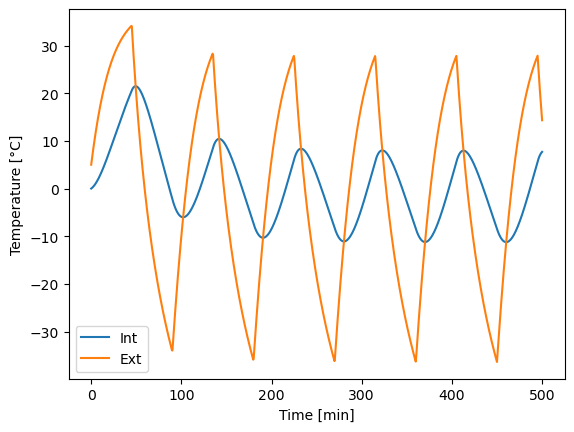

In [52]:
HYST = False

def model(y,t):
    global power
    T1 = y[0] # Internal temperature
    T2 = y[1] # External temperature

    if (t/(90*60) % 1)<0.5:
      q_s = A_s*ABS_const*J_s # Sun power
      q_a = A_p*F_a*ABS_const*J_s*a # Albedo power
    else:
      q_s = 0
      q_a = 0
    
    q_sp = A_p*F_sp*E_ext*SB_const*((T2+273.15)**4) # Satellite -> Planet radiation
    q_sr = A_r*E_ext*SB_const*((T2+273.15)**4) # Satellite -> Space radiation 

    # Power exchange between external and internal node
    if HYST == True:
        q_int=relay(T1)
    else: 
        q_int=0
        
    Pint_exch=(K*(T2-T1))+(R*((T2+273.15)**4-(T1+273.15)**4)) # Exchange power betxeen needs
    
    # Internal temperature variation
    dT1dt = (Pint_exch + q_int)/C_int
        #utilized q_int to keep heat target
        #find a peak value for Power so it doesn't get too cold; hysterisis control
    
    # External temperature variation
    dT2dt = (-Pint_exch + q_s + q_p + q_a + q_r - q_sp - q_sr)/C_ext
    
    dydt = [dT1dt,dT2dt]

    return dydt

y0 = [0,5]
t = np.linspace(0,30000,1000)
y = odeint(model,y0,t)

plt.plot(t/60,y)
plt.legend(('Int', 'Ext'))
plt.xlabel('Time [min]')
plt.ylabel('Temperature [°C]')
plt.show()

## Defining the power needs for a CubeSat Battery Pack Heating Solution

> **Exercise:** use the previous results to display the thermal power exchanged between the internal node and the external node. Deduce a minimum value for the heating power to be supplied to the batteries to maintain a constant temperature. 


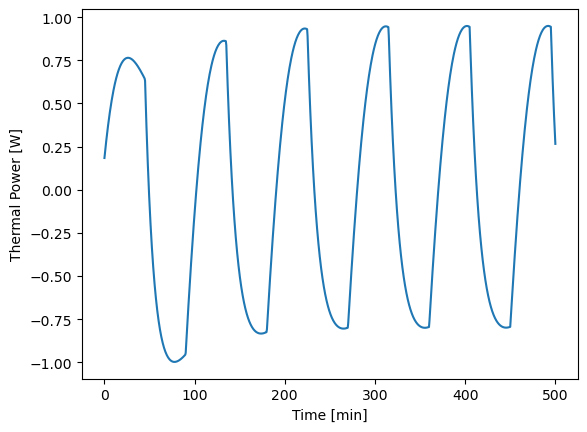

In [53]:
T1=y[:,0]
T2=y[:,1]
Pint=K*(T2-T1)+R*((T2+273.15)**4-(T1+273.15)**4)

plt.plot(t/60,Pint)
plt.xlabel('Time [min]')
plt.ylabel('Thermal Power [W]')
plt.show()


> **Exercise:** modify the numerical model to incorporate thermal relay control with hysteresis between 15 and 20°C. Test different heating value. Conclusion.

*Modelica model of relay control with hysteresis:*
![Modelica model](./figures/RelayControl.png)

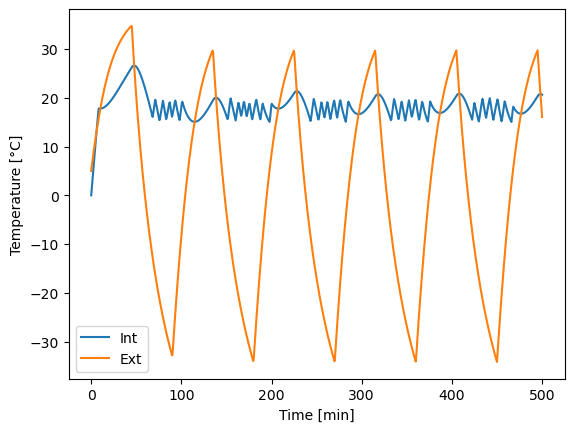

In [58]:
Heat = 3 # [W] Heat power 
StateHeat = True # [W] Heating state

def relay(Temp):
    global StateHeat, Heat
    
    if Temp > 20:
        StateHeat = False
    elif Temp < 15:
        StateHeat = True
        
    return Heat if StateHeat else 0

HYST = True

y0 = [0,5]
t = np.linspace(0,30000,1000)
y = odeint(model,y0,t)


plt.plot(t/60,y)
plt.legend(('Int', 'Ext'))
plt.xlabel('Time [min]')
plt.ylabel('Temperature [°C]')
plt.show()


## Homework

>- Propose an active solution (power resistor, silicon patch, ...) compatible with the Swisscube application (7.4 V voltage) 
>- Give components references available [here](https://fr.rs-online.com/web/)
>- Prepare 2 slides of technical justification and components selection


## References 

[Rossi, 2013] Rossi, S., & Ivanov, A. (2013). Thermal model for cubesat: A simple and easy model from the Swisscube’s thermal flight data. In *Proceedings of the International Astronautical Congress* (Vol. 13, pp. 9919-9928). [Link](https://www.researchgate.net/publication/299535685_THERMAL_MODEL_FOR_CUBESAT_A_SIMPLE_AND_EASY_MODEL_FROM_THE_SWISSCUBE%27S_THERMAL_FLIGHT_DATA)

[Cengel, 2003] Cengel, A. (2003). Heat transfer. New York: McGraw-Hill.